## Семинар 5: "Улучшение сходимости нейросетей"


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:

-   Dropout
-   Batch Normalization
-   Инициализация весов


### Часть 1: Инициализация весов


На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это.


In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
train_dataset = MNIST(".", train=True, download=True, transform=transform)
test_dataset = MNIST(".", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


In [4]:
images_train, labels_train = next(iter(train_loader))


In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy()  ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass


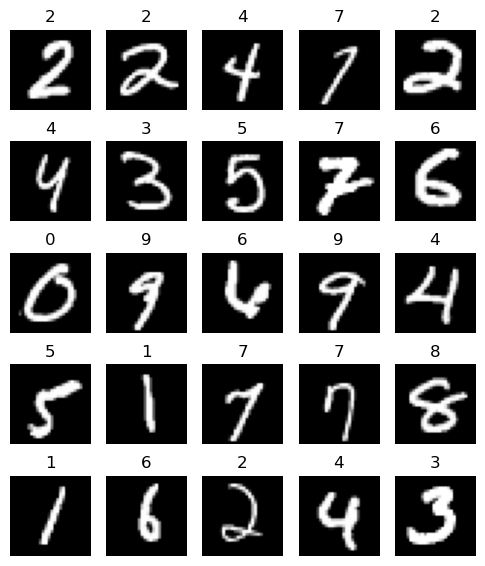

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis("off")


<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh


In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()["weight"]
    bias = layer.state_dict()["bias"]
    bias.zero_()
    weight.normal_(mean=0, std=std)


def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print("forward", std)


def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print("backward", std)


# пример:
layer = nn.Linear(28 * 28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1)  # сюда надо подставить другие параметры


<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>


In [132]:
def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print("forward", std)


def backward_hook(self, grad_input, grad_output):
    if grad_input[0] is not None:
        std = grad_input[0].std().item()
        print("backward", std)


class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 500),
            nn.Tanh(),
            nn.Linear(500, 10),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

    def init_layers(self, init_func):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                if init_func == "normal":
                    layer.weight.data.normal_(0, 0.1)
                else:
                    a = init_func(layer.in_features, layer.out_features)
                    layer.weight.data.uniform_(-a, a)
                layer.bias.data.fill_(0.0)

    def init_hooks(self, forward_hook, backward_hook):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                layer.register_forward_hook(forward_hook)
                layer.register_full_backward_hook(backward_hook)


In [133]:
network = Network()
network.init_layers("normal")
network.init_hooks(forward_hook, backward_hook)

# пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()


forward 1.000830054283142
forward 0.8494892716407776
forward 0.78477942943573
forward 0.7705570459365845
forward 0.7640563249588013
forward 0.7649234533309937
forward 0.7654111981391907
forward 0.767179012298584
forward 0.7676077485084534
forward 0.7659105658531189
forward 0.7664046883583069
forward 0.7640928626060486
backward 0.0005250011454336345
backward 0.0006389723857864738
backward 0.0007699198904447258
backward 0.0009286510176025331
backward 0.0011341285426169634
backward 0.0013540313811972737
backward 0.0016455247532576323
backward 0.0020142514258623123
backward 0.0024532098323106766
backward 0.002925836481153965
backward 0.003405054798349738


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>


In [136]:
def he(in_size, out_size):
    # gain tanh = 5/3
    std = 5.0 / 3.0 / np.sqrt(in_size)
    # если использовать uniform предлагается использовать такие границы
    return std * np.sqrt(3.0)


network = Network()
network.init_layers(he)
network.init_hooks(forward_hook, backward_hook)

activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()
optimizer.zero_grad()


forward 1.000830054283142
forward 0.7524339556694031
forward 0.6852946281433105
forward 0.6600212454795837
forward 0.6589514017105103
forward 0.6512772440910339
forward 0.6528792381286621
forward 0.6524586081504822
forward 0.6484721302986145
forward 0.6470850110054016
forward 0.6484676599502563
forward 0.6492809057235718
backward 0.0005096926470287144
backward 0.0005629504448734224
backward 0.0006215303437784314
backward 0.0006929284427314997
backward 0.000770486134570092
backward 0.0008328268304467201
backward 0.0009010978974401951
backward 0.000986179686151445
backward 0.0010785605991259217
backward 0.0011662110919132829
backward 0.001208353554829955


In [137]:
def xavier(in_size, out_size):
    std = 5.0 / 3.0 * np.sqrt(2.0 / (in_size + out_size))
    # опять же границы поправляются на sqrt(3.0)
    return std * np.sqrt(3.0)


network = Network()
network.init_layers(xavier)
network.init_hooks(forward_hook, backward_hook)

activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()


forward 1.000830054283142
forward 0.7744455933570862
forward 0.7000076174736023
forward 0.6704093813896179
forward 0.6566426753997803
forward 0.652599036693573
forward 0.6539775133132935
forward 0.6543782353401184
forward 0.6516572833061218
forward 0.6508718132972717
forward 0.6496320366859436
forward 0.6555933952331543
backward 0.0005781343206763268
backward 0.0006329533061943948
backward 0.0006855668616481125
backward 0.000752413587179035
backward 0.000821320922113955
backward 0.0009062031167559326
backward 0.0009843063307926059
backward 0.0010627418523654342
backward 0.0011635614791885018
backward 0.0012475688708946109
backward 0.0012677747290581465


<i> 1.4 Сделайте выводы по первой части </i>


С среднеквадратическим отклонением 0.1 в нормальном распределении все ок также как и с He и Xavier, если поиграться, то при единичной дисперсии градиент взорвется, при std=0.01 смоется, чего не произойдет с He и Xavier, т.к. там параметры связаны со структурой сети напрямую. He, вообще, для всяких Relu и там нормальное распределение, но делают и с равномерным (в точре есть), однако там добавляют поправку в \* sqrt(3) для uniform, с ней получается получше, градиент и не смывается, и не очень большим приходит на первые слои


### Часть 2: Dropout


Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.


<i> 2.1 Реализуйте линейный слой с DropConnect </i>


In [3]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры


class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            # с вероятностью p остается 1 и НЕ зануляется
            mask = Variable(
                torch.zeros_like(self.linear.weight.data).bernoulli_(self.p)
            )
        else:
            # в инференсе вес умножается на вероятность
            mask = Variable(torch.zeros_like(self.linear.weight.data) + self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output


<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>


In [4]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        # input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)


In [5]:
layers = [
    nn.Linear(196, 128),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(128, 10),
]


Epoch 9... (Train/Test) NLL: 0.948/0.089	Accuracy: 0.583/0.976


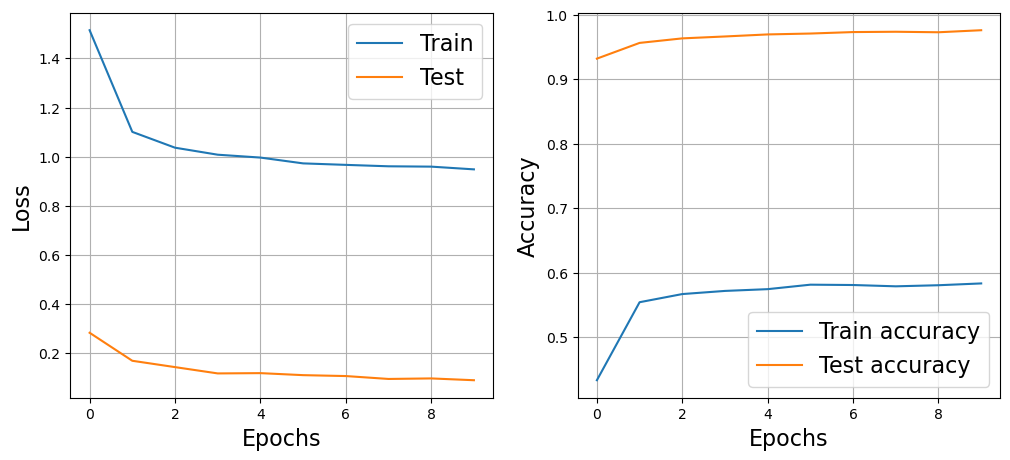

([1.5149339340897257,
  1.1007706006961082,
  1.0363240749088687,
  1.0077780955381739,
  0.9960903044956834,
  0.9723996572148825,
  0.9663443603495291,
  0.9605486874641386,
  0.9591603105002121,
  0.9480526161346354],
 [0.2823462832388999,
  0.16816960209155385,
  0.14238703609267367,
  0.11668138875614238,
  0.11785320074686521,
  0.1096311090396175,
  0.10593445594363575,
  0.09414678425351276,
  0.09629470765402046,
  0.08896946152554283],
 [0.43318564,
  0.55424887,
  0.56689763,
  0.57177836,
  0.57452136,
  0.5814621,
  0.5809402,
  0.57891905,
  0.58060145,
  0.5834055],
 [0.9322587,
  0.9566851,
  0.9637065,
  0.96667325,
  0.96983784,
  0.9712223,
  0.97349685,
  0.9739913,
  0.97320014,
  0.97636473])

In [6]:
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device="cuda")


Epoch 9... (Train/Test) NLL: 0.156/0.081	Accuracy: 0.951/0.975


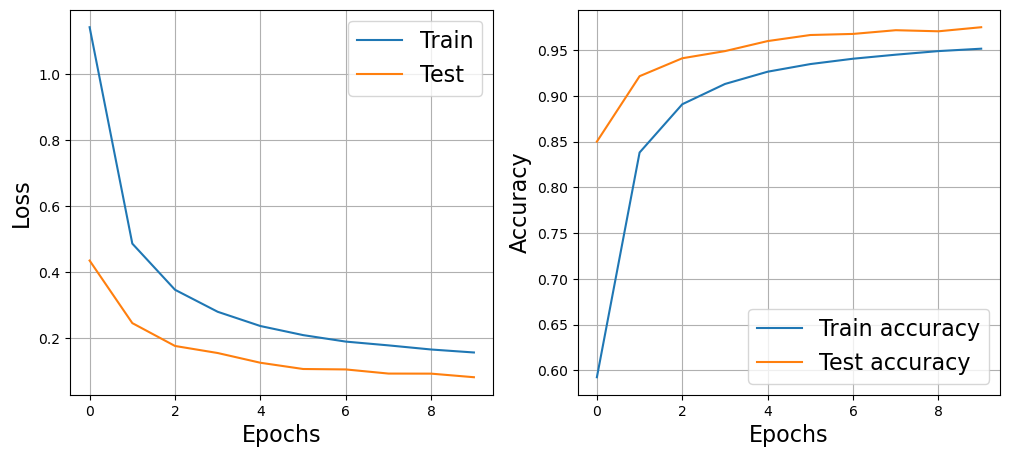

([1.1413740186548944,
  0.48581223301033477,
  0.3459756218675357,
  0.27928194440186405,
  0.23612076225184175,
  0.2086419631709168,
  0.18897137290506222,
  0.17751531386330946,
  0.1650108742450219,
  0.1560063543302545],
 [0.4344807172877879,
  0.2449869919049589,
  0.17574527920990052,
  0.1543572696892521,
  0.12486829042811937,
  0.1059605728221845,
  0.10464604935738482,
  0.09210335820341553,
  0.0918894617264218,
  0.08105217415509344],
 [0.59241736,
  0.83797526,
  0.89072496,
  0.9128743,
  0.9262838,
  0.9346237,
  0.9404651,
  0.9448794,
  0.94879395,
  0.95141476],
 [0.84988135,
  0.9213805,
  0.94096124,
  0.94877374,
  0.9597508,
  0.9663766,
  0.9675633,
  0.9716179,
  0.97043115,
  0.97488135])

In [7]:
layers = [
    DropConnect(196, 128, 0.5),
    nn.ReLU(),
    DropConnect(128, 128, 0.5),
    nn.ReLU(),
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device="cuda")


В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.


<i> 2.3 Сделайте выводы по третьей части. </i>


Dropout сильная регуляризация, с 0.5 и таким кол-вом весом у модели нет и шанса переобучиться, но по факту у нас пропадает половина нейронов и все выходы из зануленных весов соотв. С DropConnect пропадают связи, т.е. если пропадёт половина всех связей совсем не факт что это приведет к занулению половины нейронов. Тем не менее подходы работают +- в итоге одинаково. По картинкам для dropout видно что скор и лосс на трейне нереалистично себя ведут, возможно это потому что они считаются с зануленными весами на трейне. В dropconnect значит они считаются также с зануленными связями, но не со всеми, выходит что регуляризация по силе такая же, но "равномернее"


### Часть 3: Batch Normalization


Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.


<i> 3.1 Реализуйте Layer Normalization </i>


In [12]:
# полезные функции: .std(dim), .mean(dim)


class LayerNormalization(nn.Module):
    # trainable параметры
    def __init__(self, shape):
        super().__init__()
        self.gamma = nn.Parameter(torch.FloatTensor(shape).fill_(1.0))
        self.beta = nn.Parameter(torch.FloatTensor(shape).fill_(0.0))

    def forward(self, x):
        mean = x.mean(1, keepdim=True)
        std = x.std(axis=1, keepdim=True)
        output = (x - mean) / (std + 1e-5)  # для стабильности вычислений
        return output * self.gamma + self.beta


<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>


Epoch 9... (Train/Test) NLL: 0.021/0.054	Accuracy: 0.994/0.983


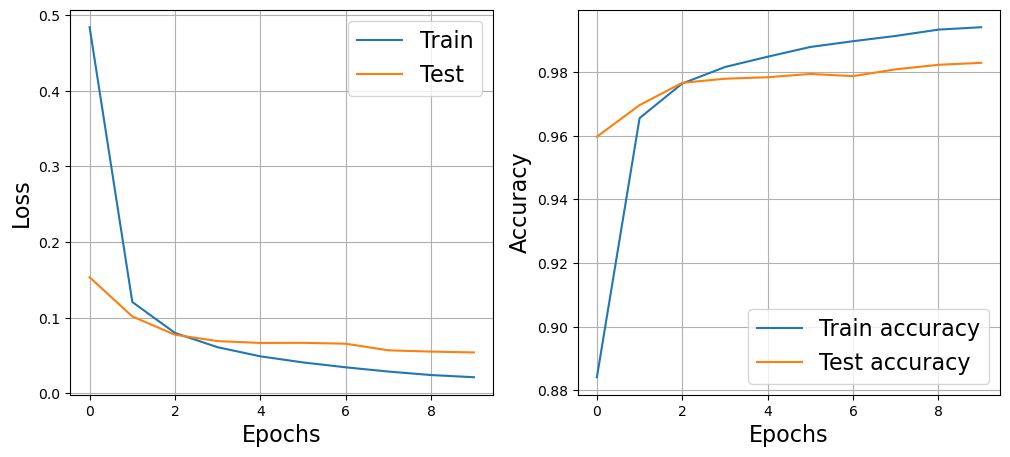

([0.4840736049464193,
  0.12087557698457928,
  0.07994839830039921,
  0.06105263660646091,
  0.04906174174304736,
  0.04098541846782979,
  0.03453749777370338,
  0.028926146563963365,
  0.0243125122387783,
  0.021449740289442114],
 [0.15353861674666405,
  0.10177570208907127,
  0.07758176866918802,
  0.06916851308196784,
  0.06675449181348085,
  0.06691936403512955,
  0.06574663240462542,
  0.05698838392272591,
  0.05531831467524171,
  0.05421333834528923],
 [0.8841367,
  0.9655279,
  0.97640806,
  0.9815722,
  0.98481643,
  0.98787296,
  0.98968816,
  0.9913434,
  0.9933241,
  0.9940744],
 [0.9596737,
  0.96961164,
  0.97660273,
  0.977901,
  0.97836626,
  0.97938883,
  0.9787167,
  0.9808537,
  0.9822725,
  0.9828929])

In [20]:
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device="cuda")


Epoch 9... (Train/Test) NLL: 0.028/0.063	Accuracy: 0.991/0.980


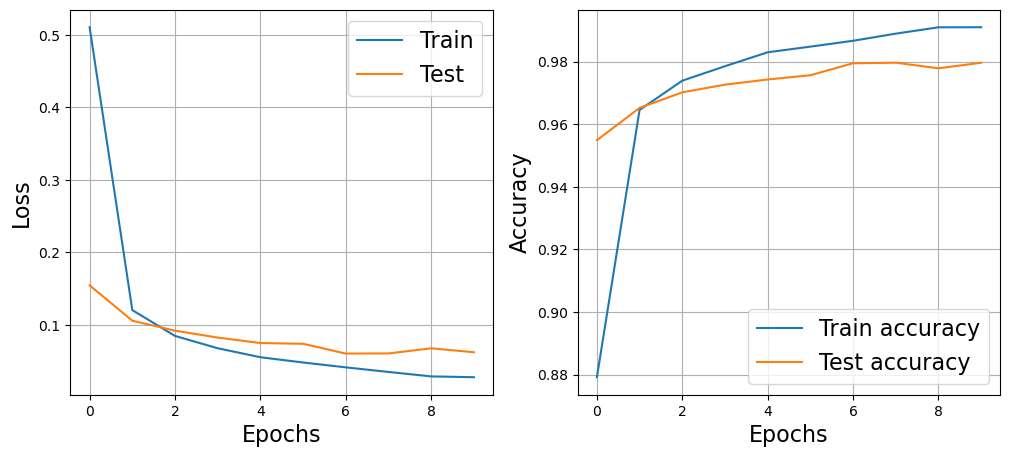

([0.5103992887977826,
  0.12056640453510366,
  0.08500124842433607,
  0.06800914754680658,
  0.0556417322101987,
  0.04838314481963545,
  0.04168997248792547,
  0.03534775857134896,
  0.029235394205898046,
  0.028094804265646863],
 [0.1547454945743084,
  0.10595390647649765,
  0.09223363623023033,
  0.08273133579641581,
  0.07520938888192177,
  0.07418391425162554,
  0.06070545129477978,
  0.06087357886135578,
  0.06794217601418495,
  0.0625204741023481],
 [0.8791435,
  0.96456784,
  0.9739197,
  0.9785487,
  0.9829957,
  0.98480535,
  0.98667574,
  0.98895437,
  0.9909792,
  0.9910068],
 [0.95489424,
  0.9652287,
  0.9701861,
  0.9726505,
  0.97429913,
  0.97566634,
  0.97948647,
  0.9796702,
  0.977878,
  0.9796473])

In [21]:
layers = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device="cuda")


<i> 3.3 Сделайте выводы по третьей части </i>


Думаю у мниста не хватает сложности чтобы увидеть разницу между batch и layer norm, т.е. свёртки извлекают достаточно хорошо признаки чтобы затем любые полносвязные слои скомбинировали фичи в класс, вне зависимости от того будет учтена для нормализации активация нейронов или свойства батча


#### Feedback (опционально)


Здесь вы можете оставить список опечаток из лекции или семинара:


Здесь вы можете оставить комментарии по лекции или семинару:
